In [79]:
# 指定各模型保存目录
base_model_dir = "../TockFormerModels/BaseModels"
scaler_dir     = "../TockFormerModels/Scalers"
blender_dir    = "../TockFormerModels/Blenders"


# 填入你保存时用的日期
date_str = "20250506"

In [80]:
import os

# 组装各文件完整路径
transformer_path = os.path.join(base_model_dir, f"Transformer_{date_str}.pth")
lstm_path        = os.path.join(base_model_dir, f"LSTM_{date_str}.pth")
ridge_path       = os.path.join(base_model_dir, f"Ridge_{date_str}.pkl")
xgbst_path       = os.path.join(base_model_dir, f"XGBST_MultiOutput_{date_str}.pkl")
scaler_path      = os.path.join(scaler_dir,     f"StandardScaler_{date_str}.pkl")
blender_path     = os.path.join(blender_dir,    f"RidgeBlender_{date_str}.pkl")

In [81]:
import torch

# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [82]:
# 加载pytorch类
from TransformerModel import TimeSeriesTransformer
from LSTMModel       import TimeSeriesLSTM


# ———— 根据你实际的超参来初始化 ————
tock = TimeSeriesTransformer(
    input_dim=49,
    model_dim=64,
    num_heads=4,
    num_layers=2,
    dropout=0.1,
    seq_length=32,
    output_dim=4
)
tock.load_state_dict(torch.load(transformer_path, map_location=device))


lstm = TimeSeriesLSTM(
    input_dim=49,
    hidden_dim=128,
    num_layers=2,
    output_dim=4
)
lstm.load_state_dict(torch.load(lstm_path, map_location=device))

<All keys matched successfully>

In [83]:
import joblib

# 加载 sklearn/XGBoost 模型与 Scaler
ridge         = joblib.load(ridge_path)
xgbst_mlt     = joblib.load(xgbst_path)
scaler        = joblib.load(scaler_path)
ridge_blender = joblib.load(blender_path)

In [84]:
import numpy as np
import pandas as pd

from Util import create_sequences, safe_inverse_transform

# 数据参数
seq_len = 32
target_cols = ["open", "high", "low", "close"]

# 读取数据
df = pd.read_csv("../TockFormerData\SPY_2025-05-01_2025-05-07_60m.csv")

df.shape

(43, 50)

In [85]:
X, y, _, target_indices = create_sequences(df, seq_length=seq_len, target_cols=target_cols, scaler=scaler)
y_true = safe_inverse_transform(y.numpy(), scaler, target_indices)

X.shape, y.shape, y_true.shape

数据被缩放


(torch.Size([11, 32, 49]), torch.Size([11, 4]), (11, 4))

In [86]:
# 各基模型预测
pred_tock = tock.predict_model(X)
pred_tock_inv = safe_inverse_transform(pred_tock, scaler, target_indices)

pred_lstm = lstm.predict_model(X)
pred_lstm_inv = safe_inverse_transform(pred_lstm, scaler, target_indices)

pred_ridge = ridge.predict(X.reshape(X.shape[0], -1))
pred_ridge_inv = safe_inverse_transform(pred_ridge, scaler, target_indices)

pred_xgb   = xgbst_mlt.predict(X.reshape(X.shape[0], -1))
pred_xgb_inv   = safe_inverse_transform(pred_xgb, scaler, target_indices)

c:\Users\hinye\miniconda3\envs\TockFormer\lib\site-packages\xgboost\core.py:2676: UserWarning: [15:44:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


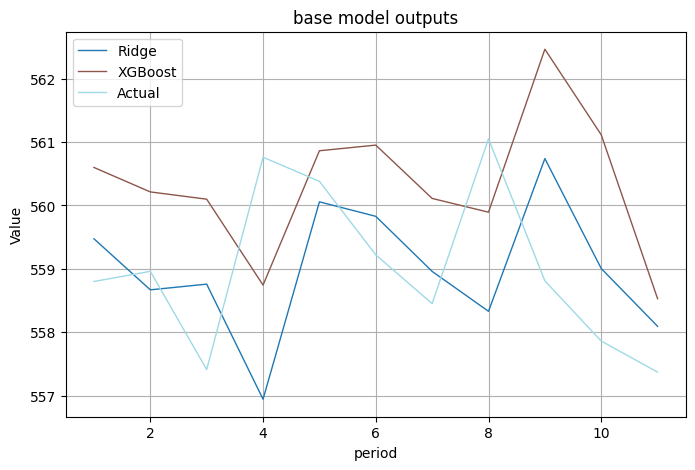

In [88]:
from Util import plot_multiple_curves

curves = {
    # "TockFormer": pred_tock_inv[:, 3],
    # "LSTM":       pred_lstm_inv[:, 3],
    "Ridge":      pred_ridge_inv[:, 3],
    "XGBoost":    pred_xgb_inv[:, 3],
    "Actual":       y_true[:, 3],
}
plot_multiple_curves(curves, title="base model outputs")


Blended 预测结果示例：
[[566.18897699 567.20184714 565.20199143 566.30176514]
 [565.42344414 566.4479463  564.42746553 565.53919715]
 [565.50155713 566.52567181 564.50547627 565.61695396]
 [564.16053553 565.20448817 563.14804423 564.28014123]
 [566.76459164 567.77072187 565.7825399  566.87557057]]


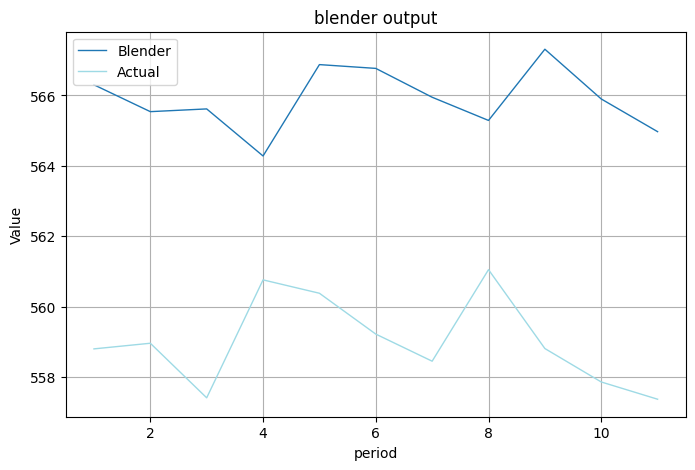

Blender MSE: [41.6327752372215, 38.422814171399914, 44.97131430808036, 49.74744937358482]


In [90]:
from sklearn.metrics import mean_squared_error

# 拼接做 Blender
# 这里假设你有4个基模型的预测结果，形状 (n_models, model_output_dim)
blend_input = np.concatenate([
    # pred_tock,
    # pred_lstm,
    pred_ridge,
    pred_xgb
], axis=1)

blend_pred = ridge_blender.predict(blend_input)
blend_pred_inv = safe_inverse_transform(blend_pred, scaler, target_indices)

print("Blended 预测结果示例：")
print(blend_pred_inv[:5])

curves = {
    "Blender": blend_pred_inv[:, 3],
    "Actual":       y_true[:, 3],
}
plot_multiple_curves(curves, title="blender output")

print("Blender MSE:", [mean_squared_error(y_true[:, i], blend_pred_inv[:, i]) for i in range(blend_pred_inv.shape[1])])
